Unzip Files - Upload mlb_data.zip

In [8]:
!unzip mlb_data.zip
from IPython.display import clear_output
clear_output(wait=False)

Imports

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
import warnings

Read in Data from File and Preprocess Data

In [10]:
# Read in data and display first 5 rows
df = pd.read_csv('mlb_data/train.csv')
df = df.dropna()

# convert pitch types to integers
unique_pitches = df.pitch_name.unique()
mapping = dic={unique_pitches[i]:i for i in range(len(unique_pitches))}
df['pitch_name'] = df['pitch_name'].replace(mapping)

# convert bearing to integer
unique_bearing = df.bearing.unique()
mapping = dic={unique_bearing[i]:i for i in range(len(unique_bearing))}
df['bearing'] = df['bearing'].replace(mapping)

# array with features to be dropped
drop_array = ['strikes','balls','bip_id','pitcher_name','batter_name','home_team','away_team','batter_team','inning','outs_when_up','game_date','bb_type']

# Adding ball park dimension data
df2 = pd.read_csv('mlb_data/park_dimensions.csv')
df2 = df2.drop(['NAME','park'],axis=1)

unique_cover = df2.Cover.unique()
mapping = dic={unique_cover[i]:i for i in range(len(unique_cover))}
df2['Cover'] = df2['Cover'].replace(mapping)

rf_w_mapping = dic={i:df2.loc[i,'RF_W'] for i in range(len(df2))}
lf_w_mapping = dic={i:df2.loc[i,'LF_W'] for i in range(len(df2))}
cf_w_mapping = dic={i:df2.loc[i,'CF_W'] for i in range(len(df2))}

rf_dim_mapping = dic={i:df2.loc[i,'RF_Dim'] for i in range(len(df2))}
lf_dim_mapping = dic={i:df2.loc[i,'LF_Dim'] for i in range(len(df2))}
cf_dim_mapping = dic={i:df2.loc[i,'CF_Dim'] for i in range(len(df2))}

cover_mapping = dic={i:df2.loc[i,'Cover'] for i in range(len(df2))}

col_names = df2.columns.tolist()

for i in range(len(df2.iloc[0])):
  df.insert(1, col_names[i], df['park'])

df['RF_W'] = df['RF_W'].replace(rf_w_mapping)
df['CF_W'] = df['CF_W'].replace(cf_w_mapping)
df['LF_W'] = df['LF_W'].replace(lf_w_mapping)

df['RF_Dim'] = df['RF_Dim'].replace(rf_dim_mapping)
df['CF_Dim'] = df['CF_Dim'].replace(cf_dim_mapping)
df['LF_Dim'] = df['LF_Dim'].replace(lf_dim_mapping)

df['Cover'] = df['Cover'].replace(cover_mapping)

# feature engineering from feature importance
df['launch_speed_root'] = df['launch_speed']**(1/2)
df['launch_angle_root'] = (df['launch_angle']+90)**(1/2)

launch_angle_avg = df.loc[:, 'launch_angle'].mean()
launch_angle_std = df.loc[:, 'launch_angle'].std()
launch_speed_avg = df.loc[:, 'launch_speed'].mean()
launch_speed_std = df.loc[:, 'launch_speed'].std()


df['launch_angle_z'] = (df['launch_angle'] - launch_angle_avg) / launch_angle_std
df['launch_speed_z'] = (df['launch_speed'] - launch_speed_avg) / launch_speed_std

df['plate_z_3'] =df['plate_z']**3
df['plate_x_3'] = df['plate_x']**3

# data to perform cross validation
x = df.drop(drop_array,axis=1)
x = x.drop(['is_home_run'],axis=1)
y = df['is_home_run']

# data to train random forest - Training/Testing is split 90/10
features = df.drop(drop_array,axis=1)
train, test = train_test_split(features,train_size=0.9,random_state=498)
train_labels = train['is_home_run']
test_labels = test['is_home_run']
train_features = train.drop(['is_home_run'],axis=1)
test_features = test.drop(['is_home_run'],axis=1)
warnings.filterwarnings('ignore')

In [11]:
print(features.columns)

Index(['RF_W', 'CF_W', 'LF_W', 'RF_Dim', 'CF_Dim', 'LF_Dim', 'Cover',
       'batter_id', 'pitcher_id', 'is_batter_lefty', 'is_pitcher_lefty',
       'bearing', 'pitch_name', 'park', 'plate_x', 'plate_z', 'pitch_mph',
       'launch_speed', 'launch_angle', 'is_home_run', 'launch_speed_root',
       'launch_angle_root', 'launch_angle_z', 'launch_speed_z', 'plate_z_3',
       'plate_x_3'],
      dtype='object')


Train Random Forest Classifier Model using Training Data - Takes about 1-2 minutes

In [12]:
# Instantiate model with 2000 decision trees
rf = RandomForestClassifier(n_estimators = 2000, random_state = 1)

# Train the model on training data
rf.fit(train_features, train_labels);

Predict Using Random Forest Classifier Model on Test Data

Accuracy: 0.9733 %


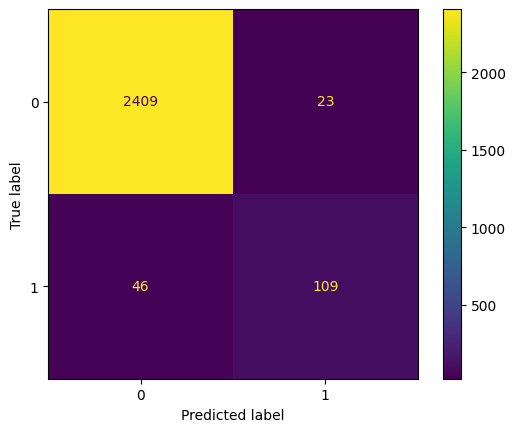

Precision [0.98126273 0.82575758]
Recall [0.99054276 0.70322581]


In [17]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out accuracy
print('Accuracy:', 1-round(np.mean(errors), 4), '%')

# create and display confusion matrix
cm = confusion_matrix(test_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
disp.plot()
plt.show()

tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()

precision = tp / tp_and_fp
recall = tp / tp_and_fn
print("Precision", precision)
print("Recall", recall)

Cross Validation for Random Forest Model Evaluation - Takes about 10 minutes

In [13]:
# 10-Fold Cross validation
print(np.mean(cross_val_score(rf, x, y, cv=10)))

0.9735130826958878


Feature Importannce Analysis

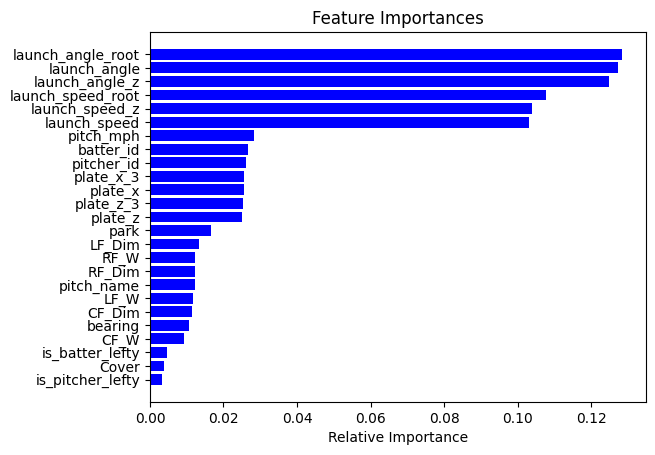

In [14]:
# get feature importances
importances = rf.feature_importances_

# get indices corresponding to features and sort features by importance
features_names = train_features.columns.tolist()
indices = np.argsort(importances)

# Plot feature importances
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Naive Bayes Model

In [15]:
gnb = GaussianNB()
y_pred = gnb.fit(train_features, train_labels).predict(test_features)

# 10-Fold Cross validation
print(np.mean(cross_val_score(gnb, x, y, cv=10)))

0.9563450394933799


Accuracy: 0.9586 %


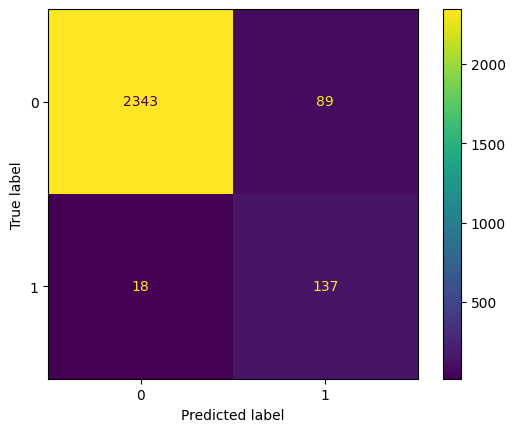

Precision [0.99237611 0.60619469]
Recall [0.96340461 0.88387097]


In [16]:
# Calculate the absolute errors
errors = abs(y_pred - test_labels)

# Print out the mean absolute error (mae)
print('Accuracy:', 1-round(np.mean(errors), 4), '%')

# create and display confusion matrix
cm = confusion_matrix(test_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
plt.show()

tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()

precision = tp / tp_and_fp
recall = tp / tp_and_fn
print("Precision", precision)
print("Recall", recall)